In [1]:
import os, sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle as pkl
%matplotlib inline

import matplotlib.patches as patches
import imageio
from scipy import ndimage as ndi
import scipy.ndimage.filters as filters
from skimage.segmentation import watershed
from tqdm.autonotebook import tqdm
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import seaborn as sns

sys.path.insert(0, os.path.abspath('..'))
from cell_detection.cell_detection import detect_cells

/home/kskozlov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  app.launch_new_instance()


Set necessary parameters for plots 

In [2]:
plt.rcParams["font.family"] = "Nimbus Sans"
plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'font.weight': 'normal'})

Here we open files, which contain cutted mappings and cutted images (we cut the full image on parts, because we wanted to give images to the input of the network with the similar scale as it was trained)    

In [3]:
with open('../data/mapping.pkl', 'rb') as f:
    preds, prev_sizes = pkl.load(f)
    
with open('../data/cutted_images.pkl', 'rb') as f:
    images = pkl.load(f)

color segmentation classes with different colors

In [4]:
colors_dict = {
    'bacteria' : (251, 186, 14),
    'matrix': (64, 105, 42),
    'channel': (55, 94, 152),
    'cells-free zone': (236, 102, 70)}

Cutted image shape

In [5]:
prev_sizes[0]

(1152, 704)

These functions are used to unite cutted segmentation maps and images to create full image

In [6]:
def unite_masks(preds, n_rows, n_columns):
    part_width = 2560
    part_height = 1760
    total_masked_image = np.zeros((n_rows*part_height, n_columns*part_width, 3), dtype=int)
    total_mask_tensor = np.zeros((n_rows*part_height, n_columns*part_width))
    counter = 0
    for pred in preds:
        mask_tensor = pred[0].argmax(axis=0)
        masked_image = np.zeros(shape=(part_height, part_width, 3))
        for i, layer in enumerate(list(colors_dict.keys())):
            masked_image[:,:][mask_tensor == i] = colors_dict[layer]
            
        y_crd  = counter // n_rows
        x_crd = counter % n_columns
        total_masked_image[(y_crd)*part_height: (y_crd+1)*part_height,
                           (x_crd)*part_width: (x_crd+1)*part_width, :] = masked_image
        
        total_mask_tensor[(y_crd)*part_height: (y_crd+1)*part_height,
                           (x_crd)*part_width: (x_crd+1)*part_width] = mask_tensor
        
        counter += 1
        
    return total_masked_image, total_mask_tensor


In [7]:
def unite_image(images, n_rows, n_columns):
    part_width = 2560
    part_height = 1760
    total_image = np.zeros((n_rows*part_height, n_columns*part_width, 3), dtype=float)
    counter = 0
    for img in images:    
        y_crd  = counter // n_rows
        x_crd = counter % n_columns
        total_image[(y_crd)*part_height: (y_crd+1)*part_height,
                           (x_crd)*part_width: (x_crd+1)*part_width, :] = img
        
        counter += 1
    
    return total_image


In [8]:
total_image = unite_image(images, n_rows=6, n_columns=6)

In [9]:
total_masked_image, total_mask_tensor = unite_masks(preds, n_rows=6, n_columns=6)

Make **cell_mask** copy to put it in *detect_cells()* function, which performs single cell detection

In [10]:
cell_mask = total_mask_tensor.copy()
cell_mask[cell_mask == 0] = 255
cell_mask[cell_mask != 255] = 0

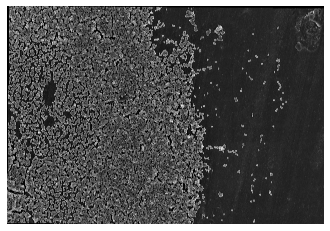

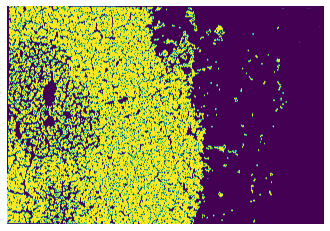

In [11]:
plt.imshow(total_image)
plt.axis('off')
plt.show()

plt.imshow(cell_mask)
plt.axis('off')
plt.show()

## Area counting

In [12]:
labels, values = np.unique(total_mask_tensor, return_counts=True)

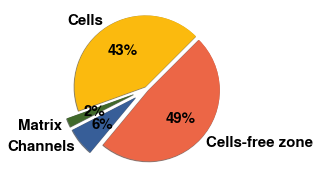

In [13]:
plt.rcParams["font.family"] = "Nimbus Sans"
plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'font.weight': 'bold'})

vals = (values/values.max())*100
labels = ["Cells", "Matrix", "Channels", "Cells-free zone"]
explode = (0.1, 0.6, 0.6, 0.1)
fig, ax = plt.subplots(figsize=(3, 3))

ax.pie(vals, labels=labels, explode=explode, colors=['#FBBA0E', '#40692A', '#375E98', '#EC6646'],
       pctdistance=0.6, radius=3, shadow=True, autopct='%1.0f%%', startangle=45, textprops=dict(color="black"))

ax.axis("equal")
#plt.savefig('area_diagram.png', dpi=300, bbox_inches='tight')
plt.show()

## Cell detection

Create function, which plots cell size histograms

In [14]:
def plot_size_hist(size_data, pixel_to_nm=1, path=None):
    sizes = []
    for s in size_data:
        sizes.append(max(s[1]))
    
    sizes = np.array(sizes) * pixel_to_nm
    
    lower_bound = np.quantile(sizes, q=0.01)
    upper_bound = np.quantile(sizes, q=0.99)
    
    plt.figure(figsize=(5, 3))
    sns.distplot(sizes[(sizes > lower_bound) & (sizes < upper_bound)], hist=True, kde=True, 
             bins=8, color = '#40692A', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
    
    sns.despine()
    
    plt.xlabel('size, nm')
    plt.ylabel('size density')
    
    
    if path:
        plt.savefig(path, dpi=300, bbox_inches='tight')
        
    plt.show()
        

Make the pictures 2.5 times larger to achieve slightly better watershed  

In [15]:
cell_mask_resized = cv2.resize(cell_mask, (17280, 10560))

In [16]:
total_image_resized = cv2.resize(total_image, (17280, 10560))

100%|██████████| 106/106 [00:18<00:00,  5.64it/s]


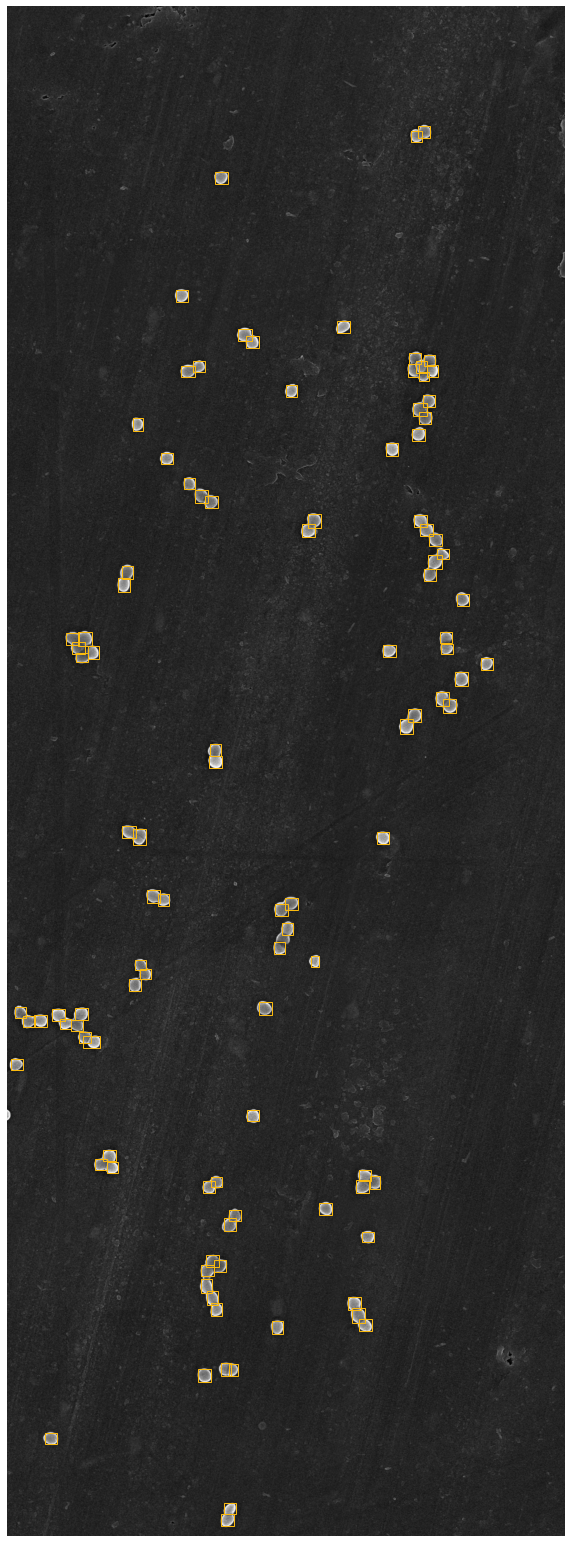

In [17]:
coords, labels = detect_cells(total_image_resized,
                              x_1=11970,
                              x_2=15750,
                              y_1=200,
                              y_2=10560,
                              cell_mask=cell_mask_resized,
                              path=None)

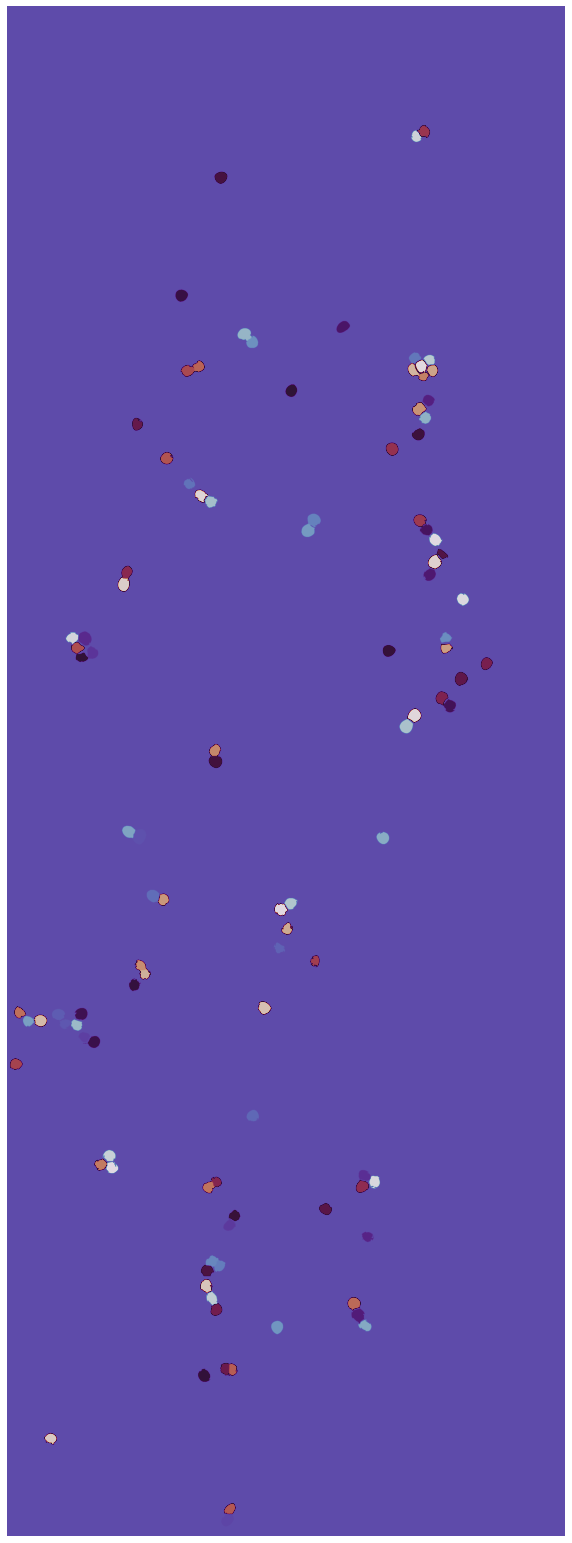

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


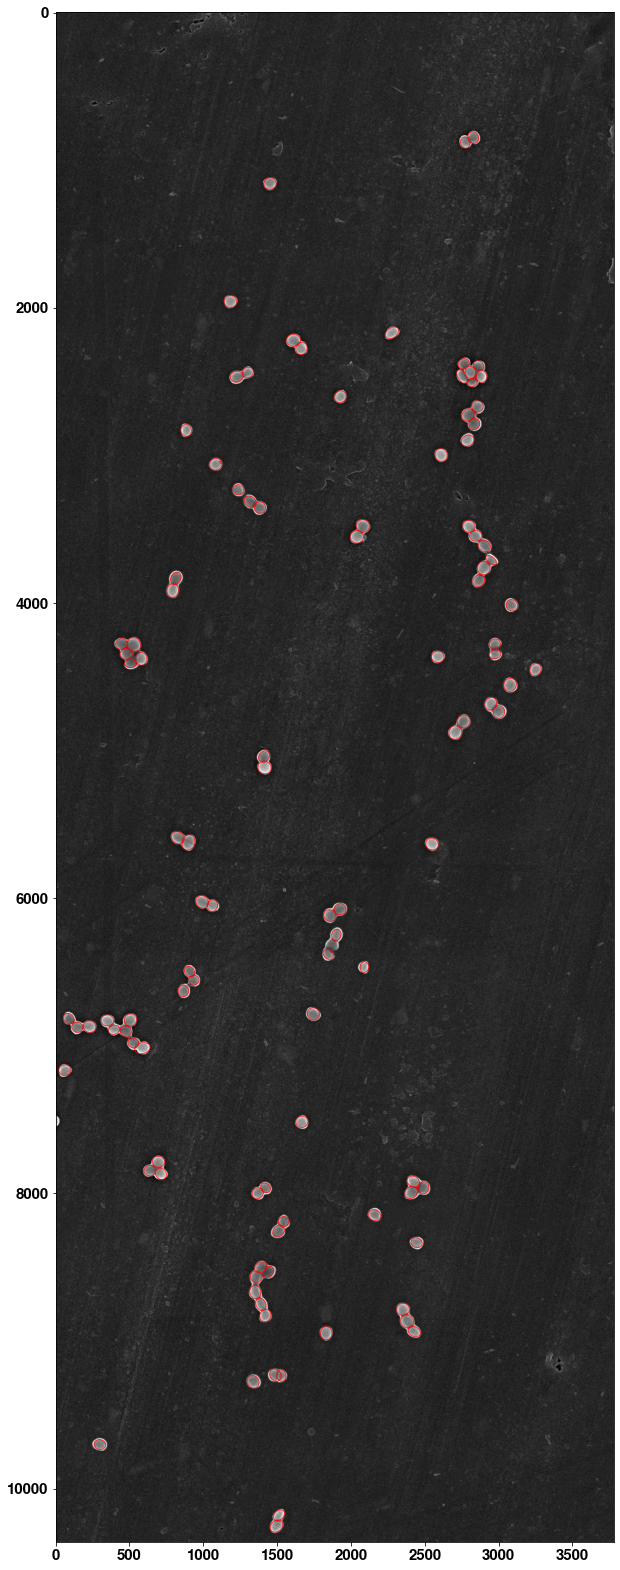

In [18]:
anal_image = total_image_resized[200:10560, 11970:15750].copy()

# instance segmentation

colors = list(range(labels.max()+1))

from random import shuffle
shuffle(colors)
colors = np.array(colors)/(labels.max()+1)

plt.figure(figsize=(10, 60))
plt.imshow(colors[labels], cmap='twilight')
plt.axis('off')
plt.show()


label_ids = list(np.unique(labels))[1:]

size_data = []
for label_id in tqdm(label_ids):

    labeled_mask = labels.copy()
    labeled_mask[labels==label_id] = 255 
    labeled_mask[labels!=label_id] = 0
    cnts, hiers = cv2.findContours(labeled_mask.astype('uint8'), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in cnts:
        try:
            ellipse = cv2.fitEllipse(cnt)
            size_data.append(ellipse)
            anal_image = cv2.ellipse(anal_image, ellipse, (255, 0, 0), 3, cv2.LINE_AA)
        except:
            pass
        
        
        
plt.figure(figsize=(10, 60))
plt.imshow(anal_image)


**Pixel_to_nm ratio** is 2.5 times less because of previous resizing

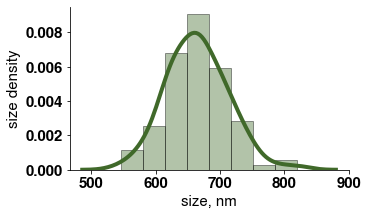

In [19]:
plot_size_hist(size_data, pixel_to_nm=19.83/2.5)

## Cluster detection

In [20]:
X = list(zip([elem[0][0] for elem in size_data], [-elem[0][1] for elem in size_data]))
X = StandardScaler().fit_transform(X)

db = DBSCAN(eps=0.1, min_samples=2).fit(X)

n_clusters_ = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
n_noise_ = list(db.labels_).count(-1)

unique_labels = set(db.labels_)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

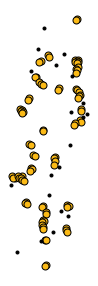

In [27]:
plt.figure(figsize=(1.5, 5))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]
    else:
        col = [251/255, 186/255, 22/255, 1]

    class_member_mask = db.labels_ == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=7,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=3,
    )

#plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.axis('off')
#plt.savefig('/home/kskozlov/files_for_research/bacteria_img_analysis/cell_clustering_3l.png', dpi=300, bbox_inches='tight')
plt.show()

In [34]:
_, cluster_sizes = np.unique(db.labels_[db.labels_!=-1], return_counts=True)
cluster_size, n_clusters = np.unique(cluster_sizes, return_counts=True)

<BarContainer object of 6 artists>

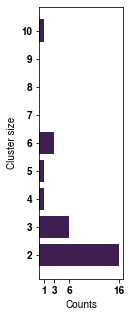

In [36]:
plt.figure(figsize=(1.5, 5))
cluster_size = list(cluster_size)
plt.yticks([2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.xticks([1, 3, 6, 16])
plt.ylabel('Cluster size')
plt.xlabel('Counts')
plt.barh(cluster_size, n_clusters, color='#3E1F51')
#plt.savefig('/home/kskozlov/files_for_research/bacteria_img_analysis/bar_chart_clustering.png', dpi=300, bbox_inches='tight')

## Density population heat map

In [37]:
width = 17280
height = 10560

In [38]:
rows = np.linspace(0, height, int(height/960)+1).astype('int')
columns = np.linspace(0, width, int(width/960)+1).astype('int')
res = np.zeros((len(rows)-1, len(columns)-1))
try:
    for i in range(len(rows)-1):
        for j in range(len(columns)-1):
            #plt.imshow(total_image_resized[rows[i]:rows[i+1], columns[j]:columns[j+1]])
            #plt.show()
            #print('y:', (rows[i], rows[i+1]), '\n', 'x:', (columns[j], columns[j+1]), '\n')

            coords, labels = detect_cells(total_image_resized,
                                          x_1=columns[j],
                                          x_2=columns[j+1],
                                          y_1=rows[i],
                                          y_2=rows[i+1],
                                          cell_mask=cell_mask_resized, figsize=None)
            res[i, j] = len(coords)
except:
    print(columns[j], columns[j+1], rows[i], rows[i+1])
        

100%|██████████| 1/1 [00:00<00:00, 8924.05it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00, 9000.65it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00, 10485.76it/s]
0it [00:00, ?it/s]
100%|██████████| 176/176 [00:00<00:00, 436.47it/s]


100%|██████████| 2/2 [00:00<00:00, 366.43it/s]


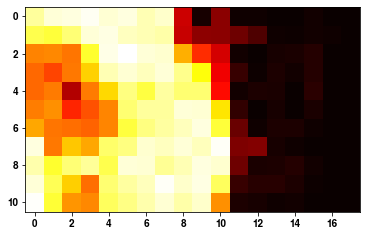

In [46]:
plt.imshow(res, cmap='hot', interpolation='nearest')
plt.show()

In [41]:
res.shape

(11, 18)

This formula as counted as below:

$ D = N_{square} / S_{square}$

$N_{square}$ - number of cells in the unit square
$S_{square}$ -  unit square are (in $\mu m^{2}$)

In [42]:
density = res / (960*7.932*10**(-3))**2

Total number of cells

In [43]:
sum(sum(res))

19064.0

Maximal cell density achieved

In [434]:
density.max()

3.4837220092702013

In [44]:
x = np.linspace(0, 0.137, 18)
y = np.linspace(0, 0.8, 11)

X, Y = np.meshgrid(x, y)

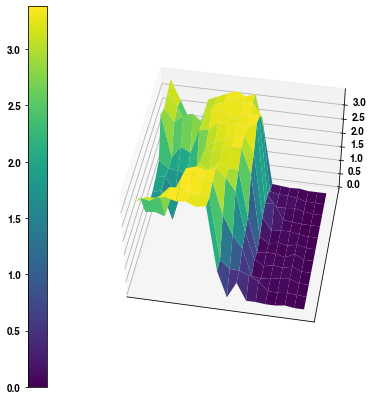

In [45]:
fig = plt.figure(figsize=(7, 7))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(X, Y, density, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.view_init(45, 280)
ax.set_xticks([])
ax.set_yticks([])
fig.colorbar(surf, location='left')
#fig.savefig('/home/kskozlov/files_for_research/bacteria_img_analysis/density_map_small.png', dpi=300, bbox_inches='tight')